## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import os
from itertools import islice

import sinogap_module as sg



### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223
sg.plt.rcParams['axes.spines.left'] = False
sg.plt.rcParams['axes.spines.right'] = False
sg.plt.rcParams['axes.spines.top'] = False
sg.plt.rcParams['axes.spines.bottom'] = False


### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 0
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize =  2**4
    ,batchSplit = 2**4
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateG = 1e-3
    ,learningRateD = 1e-3

    ,dataDir = 'data'
)

sg.DCfg = sg.DCfgClass(16,False)
secondDevice = torch.device('cuda:1')

os.environ["CTAS_MMAP_PATH"] = "/mnt/ssdData/"


### <font style="color:lightblue">Raw Read</font>

In [ ]:
sg.trainSet = sg.createDataSet(sg.TCfg.dataDir, sg.listOfTrainData, exclusive = True, expose = 0.5)
sg.trainLoader = sg.createDataLoader(sg.trainSet, num_workers=sg.TCfg.num_workers)
sg.testSet = sg.createDataSet(sg.TCfg.dataDir+"/test", sg.listOfTestData, exclusive = True)
sg.testLoader = sg.createDataLoader(sg.testSet, num_workers=sg.TCfg.num_workers)

['data/18692a.ExpChicken6mGyShift', 'data/23574.8965435L.Eiger.32kev_sft', 'data/19022g.11-EggLard', 'data/18692b.MinceO', 'data/23574.8965435L.Eiger.32kev_org', 'data/19736b.09_Feb.4176862R_Eig_Threshold-4keV', 'data/20982b.04_774784R', 'data/18515.Lamb1_Eiger_7m_45keV_360Scan', 'data/19736c.8733147R_Eig_Threshold-8keV.SAMPLE_Y1', 'data/18692b_input_PhantomM', 'data/21836b.2024-08-15-mastectomies.4201381L.35kev.20Hz', 'data/23574h.9230799R.35kev', 'data/18515.Lamb4_Excised_Eiger_7m_30keV_360Scan.Y1', 'data/18648.B_Edist.80keV_0m_Eig_Neoprene.Y2', 'data/19932.10_8093920_35keV', 'data/19932.14_2442231_23keV', 'data/19932.16_4193759_60keV']
Loading train set 1 of 17: data/18692a.ExpChicken6mGyShift ... Done
Loading train set 2 of 17: data/23574.8965435L.Eiger.32kev_sft ... 

### <font style="color:lightblue">Show</font>

In [ ]:
#st=0.6
sg.examples = [
    ((3, 476, 2880), 0.78),
    ((2, 118,  988), 0.89),
    ((0, 336, 645), 0.725),
    #((0, 298, 1557), 0.846),
    ((3, 925,  592), 0.35)
    #(0, 0, 360, 2108)
    #(0, 0, 338, 773)
    #(0, 0, 411, 1169)
]
#sg.generator.eval()
#print(st)
sg.refImages, sg.refNoises, sg.refBoxes = sg.createReferences(sg.testSet, 0)
#sg.displayImages()
#st += 0.01
#rindex = sg.showMe(sg.testSet)
#img, ridx = sg.testSet[rindex]
#print(ridx, rindex)
#sg.displayImages(img.to(sg.TCfg.device))


## <font style="color:lightblue">Models</font>

### Generator 2pix

In [ ]:
def unrollArch2(gen) :
    gen.encoders =  nn.ModuleList([
        gen.encblock( -gen.inChannels,
                           1, 3, norm=False),
        gen.encblock(  1, 2, 3, stride=2),
        gen.encblock(  2, 2, 3),
        gen.encblock(  2, 4, 3, stride=2),
        gen.encblock(  4, 4, 3),
        gen.encblock(  4, 8, 3, stride=2),
        ])
    gen.fcLink = gen.createFClink()
    gen.decoders = nn.ModuleList([
        gen.decblock(16, 4, 3, stride=2),
        gen.decblock( 8, 4, 3),
        gen.decblock( 8, 2, 3, stride=2),
        gen.decblock( 4, 2, 3),
        gen.decblock( 4, 1, 3, stride=2),
        gen.decblock( 2, 1, 3, norm=False),
        ])
    gen.lastTouch = gen.createLastTouch()
    #return gen


class DBricksGenerator2(sg.SubGeneratorTemplate) :
    # 'Adv'    : 0.000e+00
    # 'MSE'    : 8.799e-03
    # 'MSEN'   : 5.276e+00
    # 'L1L'    : 1.290e-01
    # 'L1LN'   : 7.558e+00
    # 'SSIM'   : 4.114e-04
    # 'MSSSIM' : 3.784e-06
    def __init__(self):
        super(DBricksGenerator2, self).__init__(2, True, batchNorm=True, inChannels=2)
        self.lowResGenerator = None
        self.baseChannels = 64
        unrollArch2(self)
        #sg.load_model(self, model_path="saves/aio/models/dbricks2.pt" )


class StripeGenerator2(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(StripeGenerator2, self).__init__(2, False, batchNorm=True)
        self.lowResGenerator = None
        self.baseChannels = 2
        unrollArch2(self)


class Generator2(sg.GeneratorTemplate) :
    # 'Adv'    : 0.0000+00   :
    # 'MSE'    : 9.966e-02   :   .2976
    # 'MSEN'   : 1.434e+01   :   .3517
    # 'L1L'    : 3.407e+00   :   .6491
    # 'L1LN'   : 4.572e+01   :   .6081
    # 'SSIM'   : 2.689e-04   :   .4003
    # 'MSSSIM' : 3.695e-06   :   .4075
    def __init__(self):
        super(Generator2, self).__init__(2, batchNorm=True, inChannels=4)
        self.brickGenerator = DBricksGenerator2()
        self.stripeGenerator = StripeGenerator2()
        self.baseChannels = 4
        unrollArch2(self)
        #sg.load_model(self, model_path="saves/aio/models/full2.pt" )





### Generator 4pix

In [ ]:
def unrollArch4(gen) :
    gen.encoders =  nn.ModuleList([
        gen.encblock( -gen.inChannels,
                           1, 3, norm=False),
        gen.encblock(  1, 2, 3, stride=2),
        gen.encblock(  2, 2, 3),
        gen.encblock(  2, 4, 3, stride=2),
        gen.encblock(  4, 4, 3),
        gen.encblock(  4, 8, 3, stride=2),
        gen.encblock(  8, 8, 3),
        gen.encblock(  8,16, 3, stride=2),
        ])
    gen.fcLink = gen.createFClink()
    gen.decoders = nn.ModuleList([
        gen.decblock(32, 8, 3, stride=2),
        gen.decblock(16, 8, 3),
        gen.decblock(16, 4, 3, stride=2),
        gen.decblock( 8, 4, 3),
        gen.decblock( 8, 2, 3, stride=2),
        gen.decblock( 4, 2, 3),
        gen.decblock( 4, 1, 3, stride=2),
        gen.decblock( 2, 1, 3, norm=False),
        ])
    gen.lastTouch = gen.createLastTouch()
    #return gen


class DBricksGenerator4(sg.SubGeneratorTemplate) :
    # 'Adv'    : 0.000e+00
    # 'MSE'    : 1.523e-02
    # 'MSEN'   : 2.273e+01
    # 'L1L'    : 5.012e-01
    # 'L1LN'   : 3.372e+01
    # 'SSIM'   : 5.145e-04
    # 'MSSSIM' : 4.068e-06
    def __init__(self):
        super(DBricksGenerator4, self).__init__(4, True, batchNorm=True, inChannels=2)
        self.lowResGenerator = DBricksGenerator2()
        #self.lowResGenerator.requires_grad_(False)
        self.baseChannels = 64
        unrollArch4(self)
        #sg.load_model(self, model_path="saves/aio/models/dbricks4.pt" )


class StripeGenerator4(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(StripeGenerator4, self).__init__(4, False, batchNorm=True)
        self.lowResGenerator = None
        self.baseChannels = 2
        unrollArch4(self)


class Generator4(sg.GeneratorTemplate) :
    # 'Adv'    : 0.0000+00   :
    # 'MSE'    : 4.597e-01   :   .5819
    # 'MSEN'   : 6.000e+01   :   .5839
    # 'L1L'    : 1.777e+01   :   .7987
    # 'L1LN'   : 2.033e+02   :   .7831
    # 'SSIM'   : 3.888e-04   :   .7386
    # 'MSSSIM' : 3.565e-06   :   .7840
    def __init__(self):
        super(Generator4, self).__init__(4, batchNorm=True, inChannels=4)
        self.brickGenerator = DBricksGenerator4()
        self.brickGenerator.lowResGenerator = None
        self.stripeGenerator = StripeGenerator4()
        self.lowResGenerator = Generator2()
        self.lowResGenerator.requires_grad_(False)
        self.baseChannels = 4
        unrollArch4(self)
        #sg.load_model(self, model_path="saves/aio/gap4_full/model_gen.pt" )


### Generator 8pix

In [ ]:
def unrollArch8(gen) :
    gen.encoders =  nn.ModuleList([
        gen.encblock( -gen.inChannels,
                           1, 3, norm=False),
        gen.encblock(  1, 2, 3, stride=2),
        gen.encblock(  2, 2, 3),
        gen.encblock(  2, 4, 3, stride=2),
        gen.encblock(  4, 4, 3),
        gen.encblock(  4, 8, 3, stride=2),
        gen.encblock(  8, 8, 3),
        gen.encblock(  8,16, 3, stride=2),
        gen.encblock( 16,16, 3),
        gen.encblock( 16,32, 3, stride=2),
        ])
    gen.fcLink = gen.createFClink()
    gen.decoders = nn.ModuleList([
        gen.decblock(64,16, 3, stride=2),
        gen.decblock(32,16, 3),
        gen.decblock(32, 8, 3, stride=2),
        gen.decblock(16, 8, 3),
        gen.decblock(16, 4, 3, stride=2),
        gen.decblock( 8, 4, 3),
        gen.decblock( 8, 2, 3, stride=2),
        gen.decblock( 4, 2, 3),
        gen.decblock( 4, 1, 3, stride=2),
        gen.decblock( 2, 1, 3, norm=False),
        ])
    gen.lastTouch = gen.createLastTouch()
    #return gen




class DBricksGenerator8(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(DBricksGenerator8, self).__init__(8, True, batchNorm=True, inChannels=2)
        self.baseChannels = 64
        unrollArch8(self)
        self.lowResGenerator = DBricksGenerator4()
        #sg.load_model(self, model_path="saves/aio/models/dbricks8.pt" )



class StripeGenerator8(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(StripeGenerator8, self).__init__(8, False, batchNorm=True)
        self.lowResGenerator = None
        self.baseChannels = 2
        unrollArch8(self)


class Generator8(sg.GeneratorTemplate) :
    def __init__(self):
        super(Generator8, self).__init__(8, batchNorm=True, inChannels=4)
        self.brickGenerator = DBricksGenerator8()
        self.brickGenerator.lowResGenerator = None # will use results of self.lowResGenerator instead
        self.stripeGenerator = StripeGenerator8()
        self.lowResGenerator = Generator4()
        self.baseChannels = 4
        unrollArch8(self)
        #sg.load_model(self, model_path="model_0_gen.pt" )


#generator = Generator8()
#generator.requires_grad_(False)
#def reuseLowResWeights(genP, genL) :
#    nofL = sum(1 for dummy in genL.decoders.parameters())
#    nofP = sum(1 for dummy in genP.decoders.parameters())
#    for trg, src in zip( islice(genP.encoders.parameters(), nofL),
#                         genL.encoders.parameters() ) :
#        trg[...] = src[...]
#    for trg, src in zip( islice(genP.decoders.parameters(), nofP-nofL, nofP),
#                         genL.decoders.parameters() ) :
#        trg[...] = src[...]
#    for trg, src in zip( genP.lastTouch.parameters(),
#                         genL.lastTouch.parameters() ) :
#        trg[...] = src[...]
#reuseLowResWeights(generator, generator.lowResGenerator)
#reuseLowResWeights(generator.stripeGenerator, generator.lowResGenerator.stripeGenerator)
#sg.save_model(generator, model_path="tmp.pt" )
#sg.load_model(generator, model_path="tmp.pt" )

#generator.requires_grad_(True)
#generator.lowResGenerator.requires_grad_(False)
#
#generator = generator.to(sg.TCfg.device)
#sg.generator = generator
##
#model_summary = summary(generator, input_data=[ sg.refImages[[0],...] ] ).__str__()
#print(model_summary)
#




### Generator 16pix

In [ ]:
def unrollArch16(gen) :
    gen.encoders =  nn.ModuleList([
        gen.encblock( -gen.inChannels,
                           1, 3, norm=False),
        gen.encblock(  1,  2, 3, stride=2),
        gen.encblock(  2,  2, 3),
        gen.encblock(  2,  4, 3, stride=2),
        gen.encblock(  4,  4, 3),
        gen.encblock(  4,  8, 3, stride=2),
        gen.encblock(  8,  8, 3),
        gen.encblock(  8, 16, 3, stride=2),
        gen.encblock( 16, 16, 3),
        gen.encblock( 16, 32, 3, stride=2),
        gen.encblock( 32, 32, 3),
        gen.encblock( 32, 64, 3, stride=2),
        ])
    gen.fcLink = gen.createFClink()
    gen.decoders = nn.ModuleList([
        gen.decblock(128, 32, 3, stride=2),
        gen.decblock( 64, 32, 3),
        gen.decblock( 64, 16, 3, stride=2),
        gen.decblock( 32, 16, 3),
        gen.decblock( 32,  8, 3, stride=2),
        gen.decblock( 16,  8, 3),
        gen.decblock( 16,  4, 3, stride=2),
        gen.decblock(  8,  4, 3),
        gen.decblock(  8,  2, 3, stride=2),
        gen.decblock(  4,  2, 3),
        gen.decblock(  4,  1, 3, stride=2),
        gen.decblock(  2,  1, 3, norm=False),
        ])
    gen.lastTouch = gen.createLastTouch()
    #return gen


class DBricksGenerator16(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(DBricksGenerator16, self).__init__(16, True, batchNorm=True, inChannels=3)
        self.baseChannels = 64
        unrollArch16(self)
        #self.lowResGenerator = DBricksGenerator8()
        #sg.load_model(self, model_path="saves/aio/gap16_dbricks/model_gen.pt" )
        self.lowResGenerator = None
        self.latentGenerator = self.createLatentGenerator()


class StripeGenerator16(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(StripeGenerator16, self).__init__(16, False, batchNorm=True, inChannels=2)
        self.lowResGenerator = None
        self.baseChannels = 2
        unrollArch16(self)



class FinalGenerator16(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(FinalGenerator16, self).__init__(16, False, batchNorm=True, inChannels=6)
        self.lowResGenerator = None
        self.baseChannels = 8
        self.encoders =  nn.ModuleList([
            self.encblock( -self.inChannels,
                               1, 3, norm=False),
            self.encblock( 1,  1, 3, stride=2),
            self.encblock( 1,  1, 3),
            self.encblock( 1,  1, 3, stride=2),
            self.encblock( 1,  1, 3),
            self.encblock( 1,  2, 3, stride=2),
            self.encblock( 2,  2, 3),
            self.encblock( 2,  4, 3, stride=2),
            self.encblock( 4,  4, 3),
            self.encblock( 4,  8, 3, stride=2),
            self.encblock( 8,  8, 3),
            self.encblock( 8, 16, 3, stride=2),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            self.decblock(32, 8, 3, stride=2),
            self.decblock(16, 8, 3),
            self.decblock(16, 4, 3, stride=2),
            self.decblock( 8, 4, 3),
            self.decblock( 8, 2, 3, stride=2),
            self.decblock( 4, 2, 3),
            self.decblock( 4, 1, 3, stride=2),
            self.decblock( 2, 1, 3),
            self.decblock( 2, 1, 3, stride=2),
            self.decblock( 2, 1, 3),
            self.decblock( 2, 1, 3, stride=2),
            self.decblock( 2, 1, 3, norm=False),
            ])
        self.lastTouch = self.createLastTouch()
        self.latentGenerator = self.createLatentGenerator()


class Generator16(sg.GeneratorTemplate) :


    def __init__(self):
        super(Generator16, self).__init__(16, batchNorm=True, inChannels=6)
        self.brickGenerator = DBricksGenerator16()
        self.stripeGenerator = StripeGenerator16()
        self.finalGenerator = FinalGenerator16()
        self.lowResGenerator = Generator8()
        self.createBricksMask()
        self.baseChannels = 8

        #sg.load_model(self, model_path="model_0_gen.pt" )



    def forward(self, images):

        images = images.to(sg.TCfg.device)
        # channel 0
        #with torch.no_grad() :
        preImages = self.preFill(images)
        images = self.fillTheGap(images, preImages)
        images, norms = sg.normalizeImages(images)
        stripesIn = torch.cat( (images, preImages.to(images.device)), dim=1)
        # channel 1
        stripeImages = self.stripeGenerator.forward(stripesIn)
        # refolded images into bricks
        bricksOrg = self.stripe2bricks(images).to(self.brickGenerator.device())
        brickedStipes = self.stripe2bricks(stripeImages).to(self.brickGenerator.device())
        bricksIn = torch.cat((bricksOrg, brickedStipes), dim=1)
        bricksOut = self.brickGenerator.forward(bricksIn)
        stripesOut = self.bricks2stripe(bricksOut)

        # combine channels and drop in
        modelIn = torch.cat([ img.to(self.finalGenerator.device()) \
            for img in [images, stripeImages, stripesOut, stripesOut, preImages] ], dim=1)
        results = self.finalGenerator.forward(modelIn)

        results = sg.reNormalizeImages(results, norms)#.to(imDevice)
        return results



generator = Generator16()
[
#generator.requires_grad_(False)
#def reuseLowResWeights(genP, genL) :
#    nofL = sum(1 for dummy in genL.decoders.parameters())
#    nofP = sum(1 for dummy in genP.decoders.parameters())
#    for trg, src in zip( islice(genP.encoders.parameters(), nofL),
#                         genL.encoders.parameters() ) :
#        trg[...] = src[...]
#    for trg, src in zip( islice(genP.decoders.parameters(), nofP-nofL, nofP),
#                         genL.decoders.parameters() ) :
#        trg[...] = src[...]
#    for trg, src in zip( genP.lastTouch.parameters(),
#                         genL.lastTouch.parameters() ) :
#        trg[...] = src[...]
##reuseLowResWeights(generator, generator.lowResGenerator)
#reuseLowResWeights(generator.stripeGenerator, generator.lowResGenerator.stripeGenerator)
#for trg, src in zip( generator.fcLink.parameters(),
#                     generator.lowResGenerator.fcLink.parameters() ) :
#    trg[...] = src[...]
##sg.save_model(generator, model_path="tmp.pt" )
##sg.load_model(generator, model_path="tmp.pt" )


#generator_new = Generator16_new()
#generator_new.requires_grad_(False)
#for trg, src in zip( generator_new.parameters(), generator.parameters() ) :
#    orgSh = src.shape
#    subRange = np.s_[ [ np.s_[0:dm] for dm in src.shape ] ]
#    trg[subRange] = src[subRange]
#sg.save_model(generator_new, model_path="tmp.pt" )

#generator.brickGenerator.latentGenerator = generator.brickGenerator.createLatentGenerator()
#generator.finalGenerator = FinalGenerator16()
#generator.finalGenerator.requires_grad_(False)
#generator.requires_grad_(False)
#for trg, src in zip( generator.finalGenerator.encoders.parameters(), generator.encoders.parameters()  ) :
#    trg[...] = src[...]
#for trg, src in zip( generator.finalGenerator.fcLink.parameters(), generator.fcLink.parameters()  ) :
#    trg[...] = src[...]
#for trg, src in zip( generator.finalGenerator.decoders.parameters(), generator.decoders.parameters()  ) :
#    trg[...] = src[...]
#for trg, src in zip( generator.finalGenerator.lastTouch.parameters(), generator.lastTouch.parameters()  ) :
#    trg[...] = src[...]
#
#del generator.encoders
#del generator.fcLink
#del generator.decoders
#del generator.lastTouch
#
#divgive=0#0.05
#for param in generator.brickGenerator.latentGenerator.parameters() :
#    torch.nn.init.normal_(param, mean=0, std=divgive)
##torch.nn.init.normal_( next(sg.generator.brickGenerator.encoders[0][0].parameters())[:,-1,...] , mean=0, std=divgive)
#
#divgive=0#0.2
#for param in generator.finalGenerator.latentGenerator.parameters() :
#    torch.nn.init.normal_(param, mean=0, std=divgive)
##torch.nn.init.normal_( next(sg.generator.finalGenerator.encoders[0][0].parameters())[:,-1,...] , mean=0, std=divgive)
#
#sg.save_model(generator, model_path="tmp.pt" )
]




#sg.save_model(generator, model_path="tmp.pt" )
#del sg.generator.brickGenerator.latentGenerator
#generator.brickGenerator.latentGenerator = 1.1
#del sg.generator.finalGenerator.latentGenerator
#generator.finalGenerator.latentGenerator = 1.1

model_summary = summary(generator, input_data=[ sg.refImages[[0],...].to('cpu') ] ).__str__()
print(model_summary)


generator = generator.to(sg.TCfg.device)
sg.generator = generator


Layer (type:depth-idx)                                       Output Shape              Param #
Generator16                                                  [1, 1, 4096, 128]         --
├─Generator8: 1-1                                            --                        --
│    └─Generator4: 2-1                                       --                        --
│    │    └─Generator2: 3-1                                  --                        (57,318,458)
│    │    └─StripeGenerator4: 3-2                            --                        33,590,446
│    │    └─DBricksGenerator4: 3-3                           --                        61,737,411
│    │    └─ModuleList: 3-4                                  --                        37,076
│    │    └─Sequential: 3-5                                  [1, 64, 64, 2]            134,234,112
│    │    └─ModuleList: 3-6                                  --                        73,676
│    │    └─Sequential: 3-7                         

### <font style="color:lightblue">Discriminator</font>

In [ ]:
def unrollDisArch16(gen) :
    gen.body =  nn.Sequential(
        gen.encblock( -gen.inChannels,
                           1, 3, norm=False),
        gen.encblock(  1,  2, 3, stride=2),
        gen.encblock(  2,  2, 3),
        gen.encblock(  2,  4, 3, stride=2),
        gen.encblock(  4,  4, 3),
        gen.encblock(  4,  8, 3, stride=2),
        gen.encblock(  8,  8, 3),
        gen.encblock(  8, 16, 3, stride=2),
        gen.encblock( 16, 16, 3),
        gen.encblock( 16, 32, 3, stride=2),
        gen.encblock( 32, 32, 3),
        gen.encblock( 32, 64, 3, stride=2),
        )
    gen.head = gen.createHead(16)

class DiscriminatorStripe(sg.DiscriminatorTemplate):

    def __init__(self):
        super(DiscriminatorStripe, self).__init__()
        self.inChannels = 1
        self.baseChannels = 32
        unrollDisArch16(self)
        #sg.load_model(self, model_path="tmp_disc_init.pt" )
        #sg.load_model(self, model_path="model_0_hourly_dis.pt" )

class DiscriminatorBrick(sg.DiscriminatorTemplate):

    def createHead(self, chMid) :
        encSh = self.body(torch.zeros((1,1,*generator.brickGenerator.cfg.sinoSh))).shape
        linChannels = math.prod(encSh)
        chMid *= self.baseChannels
        toRet = nn.Sequential(
            nn.Flatten(),
            #nn.Dropout(0.4),
            nn.Linear(linChannels, chMid),
            #nn.Linear(linChannels, 1),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.4),
            nn.Linear(chMid, 1),
            nn.Sigmoid(),
        )
        sg.fillWheights(toRet)
        return toRet

    def __init__(self):
        super(DiscriminatorBrick, self).__init__()
        self.inChannels = 1
        self.baseChannels = 64
        unrollDisArch16(self)
        sg.fillWheights(self.parameters())



class Discriminator(sg.DiscriminatorTemplate):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.brickDiscriminator = DiscriminatorBrick()
        self.stripeDiscriminator = DiscriminatorStripe()

    def forward(self, images):

        sinoSh = generator.brickGenerator.cfg.sinoSh
        imsz = math.prod(sinoSh)
        nofIm = images.shape[0]
        bricks = images.view(nofIm,-1)
        bricks = bricks.unfold(1,imsz,imsz//2).unfold(2,*sinoSh)
        bricks = bricks.reshape(-1,1,*sinoSh)
        toRet = 0.5 * ( self.brickDiscriminator.forward(bricks).mean() +
                        self.stripeDiscriminator.forward(images) )
        return toRet



sg.discriminator = Discriminator()
sg.load_model(sg.discriminator, model_path="model_0_hourly_dis.pt" )
#sg.discriminator.requires_grad_(False)
#for param in sg.discriminator.parameters() :
#    torch.nn.init.normal_(param, mean=0, std=0.00025)
#    #param *= torch.randn_like(param)*0.01 + 1.0

model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...].to('cpu') ).__str__()
print(model_summary)
#sg.discriminator = sg.discriminator.to(sg.TCfg.device)
#print(sg.discriminator(sg.refImages.to('cpu')))

#sg.discriminator.to(secondDevice)
#sg.discriminator.requires_grad_(True)
#sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD/1000)
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1-0.0001)



Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─DiscriminatorBrick: 1-1                --                        --
│    └─Sequential: 2-1                   [63, 4096, 2, 2]          --
│    │    └─Sequential: 3-1              [63, 64, 128, 128]        640
│    │    └─Sequential: 3-2              [63, 128, 64, 64]         73,856
│    │    └─Sequential: 3-3              [63, 128, 64, 64]         147,584
│    │    └─Sequential: 3-4              [63, 256, 32, 32]         295,168
│    │    └─Sequential: 3-5              [63, 256, 32, 32]         590,080
│    │    └─Sequential: 3-6              [63, 512, 16, 16]         1,180,160
│    │    └─Sequential: 3-7              [63, 512, 16, 16]         2,359,808
│    │    └─Sequential: 3-8              [63, 1024, 8, 8]          4,719,616
│    │    └─Sequential: 3-9              [63, 1024, 8, 8]          9,438,208
│    │    └─Sequential: 3-10         

## <font style="color:lightblue">Norms</font>

In [ ]:
#sg.testLoader = sg.createDataLoader(sg.testSet, num_workers=0)
#_ = sg.summarizeMe(sg.testLoader, True)
#_ = sg.summarizeMe(sg.testLoader, False)
#_ = sg.summarizeMe(sg.dataLoader, True)
#_ = sg.summarizeMe(sg.dataLoader, False)
#sg.displayImages()


### no prenorm
sg.EAGLE = sg.Eagle_Loss(patch_size=3, device=sg.TCfg.device, cutoff=0.75)
sg.metrices = {
    'EAGLE'  : sg.Metrics(sg.loss_EAGLE,   1.601e+05, 0), # 1.219e+03 # cutoff=0.25
    'MSE'    : sg.Metrics(sg.loss_MSE,     5.543e+01, 0.01),
    'MSEN'   : sg.Metrics(sg.loss_MSEN,    2.943e+03, 0),
    'L1L'    : sg.Metrics(sg.loss_L1L,     8.302e+02, 0), # 1/1.8
    'L1LN'   : sg.Metrics(sg.loss_L1LN,    7.452e+03, 0), # 1/3.5
    'SSIM'   : sg.Metrics(sg.loss_SSIM,    4.946e-04, 0),
    'MSSSIM' : sg.Metrics(sg.loss_MSSSIM,  1.120e-06, 0),
    'STD'    : sg.Metrics(sg.loss_STD,     1.823e-02, 0),
    'COR'    : sg.Metrics(sg.loss_COR,     6.607e-02, 0),
    'Adv'    : sg.Metrics(sg.loss_Adv_Gen, 6.932e-01, 1), # 6.932e-01
}
#sg.trackExtremes(False)
#_ = sg.summarizeMe(sg.testLoader, True)



# brick-only estimation
#generator.brickGenerator.lowResGenerator = DBricksGenerator4()
#sg.load_model(generator.brickGenerator.lowResGenerator, model_path="saves/aio/models/dbricks4.pt" )
#generator = generator.to(sg.TCfg.device)
#_ = sg.summarizeMe(sg.testLoader, False)



#sg.displayImages()

## <font style="color:lightblue">Restore checkpoint</font>

In [ ]:
sg.freeGPUmem()
sg.freeGPUmem()
#sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1)
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1)


savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minGEpoch, sg.minGLoss, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint(savedCheckPoint+"_hourly.pth")
sg.startFrom = 0
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGLoss, sg.startFrom = 17, 1045000, 15, 0.972, 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages),) )
#sg.writer.add_graph(sg.discriminator, refImages)
#sg.optimizers_G  = [sg.optimizer_G,]

#sg.generator.lowResGenerator.to(secondDevice)
#sg.generator.stripeGenerator.to(secondDevice)
#sg.generator.brickGenerator.to(sg.TCfg.device)
#sg.generator.finalGenerator.to(sg.TCfg.device)


#sg.load_model(sg.discriminator, model_path="tmp_disc_init.pt" )
#sg.load_model(sg.generator, model_path="model_1_gen.pt" )
#sg.load_model(sg.generator.brickGenerator, model_path="saves/complex/models/bricks4.pt" )
#sg.load_model(sg.generator.lowResGenerator, model_path="saves/complex/models/stripe2.pt" )
#sg.generator.brickGenerator.lowResGenerator.requires_grad_(False)
#sg.generator.stripeGenerator.lowResGenerator.requires_grad_(False)



#sg.scheduler_G.gamma = 1-0.01
#sg.scheduler_D.gamma = 1-0.005
#sg.optimizer_G.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 1).step()
#sg.optimizer_D.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 0.05).step()

if sg.scheduler_G is not None:
    print(sg.epoch, sg.imer)
    print(f"Initial LR : G {sg.scheduler_G.get_last_lr()[0]:.3e} ({sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG:.4f})")
                  #f" D {sg.scheduler_D.get_last_lr()[0]:.3e} ({sg.scheduler_D.get_last_lr()[0]/sg.TCfg.learningRateD:.4f}), Epoch {sg.epoch} {sg.imer}")


sg.freeGPUmem()
sg.freeGPUmem()



ValueError: loaded state dict contains a parameter group that doesn't match the size of optimizer's group

## <font style="color:lightblue">Optimizers</font>

In [ ]:
#sg.generator.brickGenerator.latentGenerator = sg.generator.brickGenerator.createLatentGenerator()
#sg.generator.finalGenerator.latentGenerator = sg.generator.finalGenerator.createLatentGenerator()
#sg.load_model(sg.generator, model_path="tmp.pt" )
if True :
    #if False :

        sg.generator.lowResGenerator.to(secondDevice)
        sg.generator.stripeGenerator.to(secondDevice)
        sg.generator.brickGenerator.to(sg.TCfg.device)
        sg.generator.finalGenerator.to(secondDevice)

        sg.generator.requires_grad_(True)

        sg.generator.lowResGenerator.requires_grad_(False)
        sg.generator.stripeGenerator.requires_grad_(True)
        sg.generator.brickGenerator.requires_grad_(True)
        sg.generator.finalGenerator.requires_grad_(True)

        sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG / 100 )
        sg.optimizers_G  = [sg.optimizer_G,]
        sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizers_G[0], 1, gamma=1-0.005)

        sg.discriminator.to(secondDevice)
        sg.discriminator.requires_grad_(True)
        sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD / 100)
        sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1-0.005)

        #checkPoint = torch.load(savedCheckPoint+"_hourly.pth", map_location='cpu', weights_only=False)
        #sg.optimizer_G.load_state_dict(checkPoint['optimizerGen'])
        #sg.optimizer_D.load_state_dict(checkPoint['optimizerDis'])



if sg.scheduler_G is not None:
    print(sg.epoch, sg.imer)
    print(f"Initial LR : G {sg.scheduler_G.get_last_lr()[0]:.3e} ({sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG:.4f})")
if sg.scheduler_D is not None:
    print(f"Initial LR : D {sg.scheduler_D.get_last_lr()[0]:.3e} ({sg.scheduler_D.get_last_lr()[0]/sg.TCfg.learningRateD:.4f})")


28 2441768
Initial LR : G 1.000e-05 (0.0100)
Initial LR : D 1.000e-05 (0.0100)


## <font style="color:lightblue">Display</font>

28 2441768
tensor([[0.7337],
        [0.7495],
        [0.6972],
        [0.6740]], device='cuda:1')


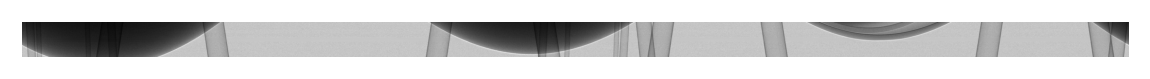

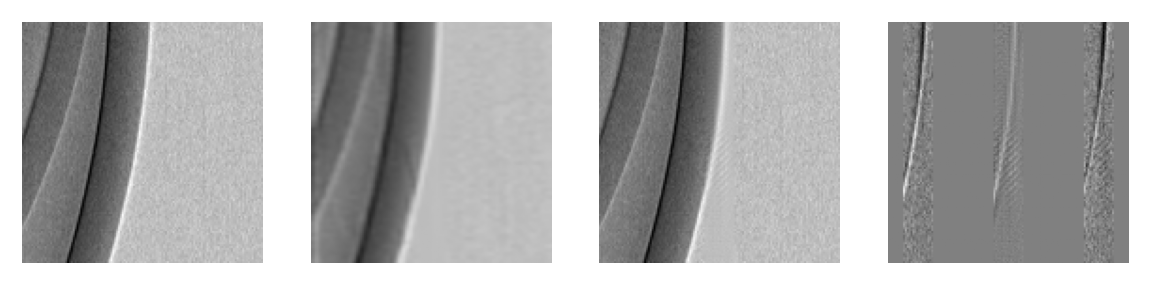

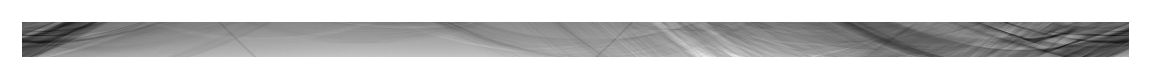

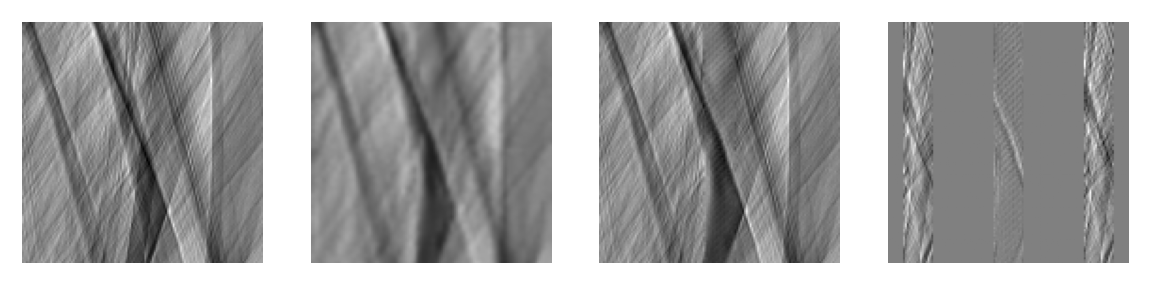

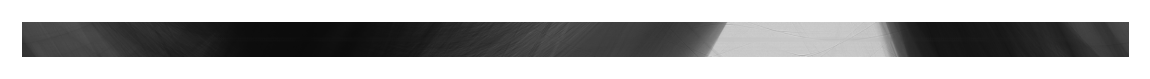

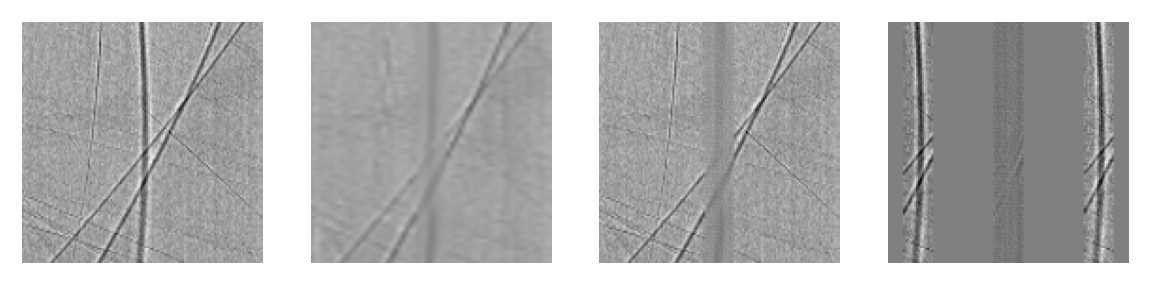

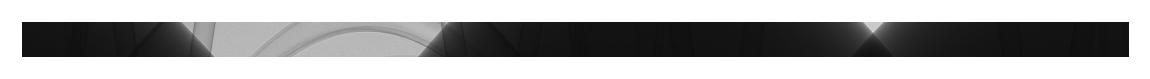

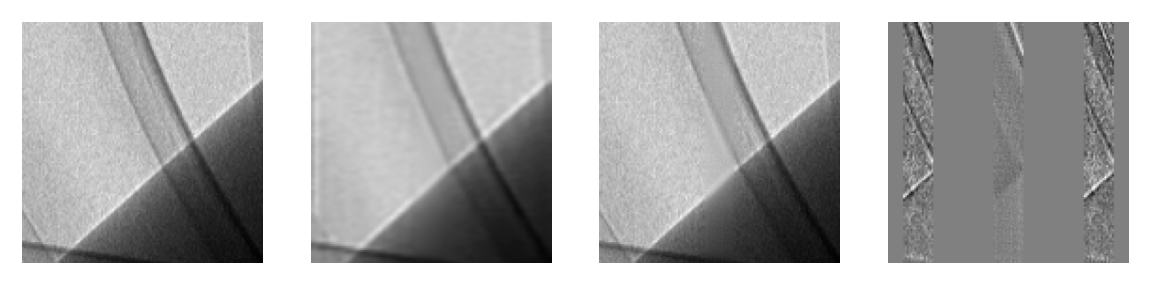

In [ ]:
print(sg.epoch, sg.imer)

def reinit(model, mean=0, std=1):
    for param in model.parameters() :
        torch.nn.init.normal_(param, mean=mean, std=std)
def renoise(model, std=1):
    for param in model.parameters() :
        param.data += torch.randn_like(param.data) * std
#reinit(sg.generator.brickGenerator.lastTouch, std=0.00001, mean=0.0)
#reinit(sg.generator.finalGenerator.latentGenerator, std=0.2)
#del sg.generator.brickGenerator.latentGenerator
#sg.generator.brickGenerator.latentGenerator = 1.1
#del sg.generator.finalGenerator.latentGenerator
#sg.generator.finalGenerator.latentGenerator = 1.1

#sg.discriminator.to(secondDevice)
#sg.discriminator.requires_grad_(True)
#sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD / 1000)
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1-0.0001)


#sg.generator.requires_grad_(False)
#sg.load_model(sg.generator, model_path="saves/afterleave_dis/model_gen.pt" )
#sg.save_model(sg.generator.brickGenerator, model_path="tmpbr.pt" )
#sg.load_model(sg.generator.brickGenerator, model_path="tmpbr.pt" )
#for idx in range(2,4) : sg.generator.finalGenerator.encoders[0][0].weight[:,idx,...] *= 2
#sg.save_model(sg.generator, model_path="tmp.pt" )


sg.generator.eval()
with torch.no_grad() :
    print(sg.discriminator(sg.refImages))
    _ = sg.displayImages()
#_ = sg.summarizeMe(sg.testLoader, False)


## <font style="color:lightblue">Execute</font>

GLR : 9.851e-06 (9.900e-03). DLR : 9.851e-06 (9.900e-03). 
Epoch: 29 (15).  Images: 32. DIS: 1.209e+00, GEN: 1.851e+00. Probs: True 2.490e-01, Fake 2.490e-01.
Individual losses: EAGLE: 1.435e+00  MSE: 2.432e+00  MSEN: 8.077e+00  L1L: 2.187e+00  L1LN: 3.679e+00  SSIM: 2.364e+00  MSSSIM: 4.304e+00  STD: 1.931e+00  COR: 5.184e+00  Adv: 1.845e+00 



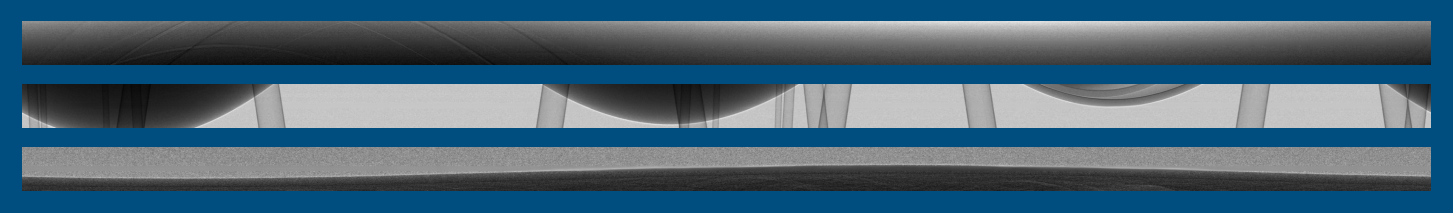

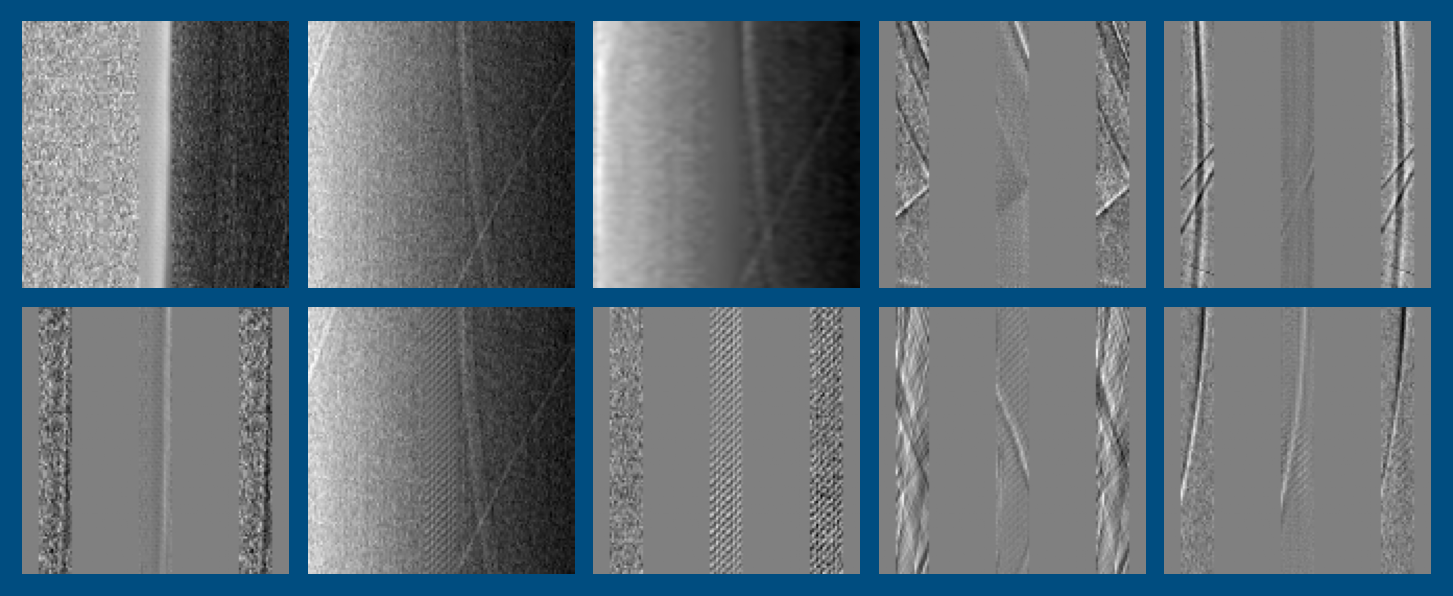

  0%|          | 7/2561 [04:40<28:22:55, 40.01s/it]


KeyboardInterrupt: 

In [ ]:


sg.freeGPUmem()
sg.freeGPUmem()

torch.optim.lr_scheduler.LambdaLR(sg.optimizers_G[0], lambda epoch: 1).step()
torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 0.1).step()
#sg.scheduler_G.gamma = 1-0.001
#sg.scheduler_G.gamma = 1-0.001
def my_beforeReport(sglocals) :
    #return
    message = ""

    message += "G" + sg.adjustScheduler(sg.scheduler_G, sg.TCfg.learningRateG, 1e-4)
    sg.writer.add_scalars("Aux", {'LrnRate': sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG}, sg.imer)
    message += "D" + sg.adjustScheduler(sg.scheduler_D, sg.TCfg.learningRateD, 1e-4)


    #for metrics in ('L1L','SSIM','MSSSIM') :
    #    sg.metrices[metrics].weight = max(0, sg.metrices[metrics].weight - 0.005)
    #    message += f"{metrics} weight: {sg.metrices[metrics].weight}. "
    #    sg.writer.add_scalars("Aux", {metrics: sg.metrices[metrics].weight}, sg.imer)

    print(message)
sg.beforeReport = my_beforeReport


def my_beforeEachEpoch(sglocals) :
    return
    sg.TCfg.batchSize = min(2**12, sg.TCfg.batchSize * 2)
    sg.TCfg.batchSplit = max(2**0, int(sg.TCfg.batchSize / 2**3))
    sg.writer.add_scalars("Aux", {'Batch size': math.log(sg.TCfg.batchSize,2)}, sg.imer)
    print(f"Batch size: {sg.TCfg.batchSize}, split: {sg.TCfg.batchSplit}", )
#sg.beforeEachEpoch = my_beforeEachEpoch

sg.repeatGen = 1
def my_doTrainGen(sglocals) :
    #print(sglocals['disLoss'])
    #return sglocals['disLoss'] > 0.7
    #return False
    return False
sg.doTrainGen = my_doTrainGen


def my_doTrainDis(sglocals) :
    #print(sglocals['disLoss'])
    #return sglocals['disLoss'] > 0.7
    #return False
    return True
#sg.doTrainDis = my_doTrainDis


#sg.TCfg.num_workers=0
try :
    sg.train(savedCheckPoint)
except :
    #del sg.dataLoader
    #del sg.testLoaderhuiVam
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise



# bricks pretrained


## <font style="color:lightblue">Post</font>

In [ ]:
sg.saveCheckPoint(savedCheckPoint+".pth",
                           sg.epoch+1, sg.imer, sg.minGEpoch, sg.minGLoss,
                           sg.generator, sg.discriminator,
                           sg.optimizer_G, sg.optimizer_D)


In [ ]:
for key in sg.resAcc.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices per epoch", {key : sg.resAcc.metrices[key],}, sg.epoch )

resTest = sg.summarizeMe(sg.testLoader, False)
resTest *= 1/resTest.nofIm
sg.writer.add_scalars("Losses epoch test",
                   {'Dis': resTest.lossD
                   ,'Gen': resTest.lossG
                   #,'Adv' : resTest.metrices['Adv']
                   }, sg.epoch )
for key in resTest.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices epoch test", {key : resTest.metrices[key],}, sg.epoch )
sg.writer.add_scalars("Probs epoch test",
                   {'Ref':resTest.predReal
                   ,'Gen':resTest.predFake
                   #,'Pre':trainRes.predGen
                   }, sg.epoch )





In [ ]:
print(sg.epoch, sg.imer, sg.minGEpoch, sg.minGLoss, sg.startFrom)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.save_model(generator.stripeGenerator, "tmp_stripe.pt")